# Elementy Inteligencji Obliczeniowej - Sieci Neuronowe


---

**Prowadzący:** Jakub Bednarek<br>
**Kontakt:** jakub.bednarek@put.poznan.pl<br>
**Materiały:** [Strona WWW](http://jakub.bednarek.pracownik.put.poznan.pl)

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji

## Cel ćwiczeń:
- zapoznanie się z Keras subclassing API
- stworzenie własnych modeli i warstw z wykorzystaniem Keras subclassing API
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [8]:
%tensorflow_version 2.x

import tensorflow as tf
import numpy as np

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [9]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Layer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta, RMSprop
from tensorflow.python.keras import backend as K


In [10]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


x_train = x_train[:, :, :, np.newaxis].astype('float32')
x_test = x_test[:, :, :, np.newaxis].astype('float32')
x_train /= 255
x_test /= 255

# x_train = x_train.reshape(60000, 784)
# x_test = x_test.reshape(10000, 784)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Tworzenie własnych modeli i warstw 
https://www.tensorflow.org/tutorials/customization/custom_layers

https://www.tensorflow.org/guide/keras/custom_layers_and_models

Przykładowy model z warstwami gęstymi dla danych MNIST:

In [ ]:
class DenseModel(Model):

  def __init__(self, num_classes=10):
    super(DenseModel, self).__init__(name='my_model')
    self.num_classes = num_classes
    # Define your layers here.
    self.dense_1 = Dense(512, input_shape=(784,), activation='relu')
    self.dense_2 = Dense(512, activation='relu')
    self.dense_3 = Dense(num_classes, activation='softmax')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    return self.dense_3(x)

model = DenseModel(num_classes=10)

In [ ]:
model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=32, epochs=3)

Epoch 1/3


ValueError: ignored

Przykład własnej warstwy. Warstwa to po prostu funkcjonalny moduł do wielokrotnego używania, podczas gdy model to gotowe rozwiązanie dla danego problemu uczenia maszynowego (tzn. w Kerasie zazwyczaj kompletna sieć neuronowa), które udostępnia dodatkowo takie metody jak `fit`, `evaluate` i `predict`. Oczywiście można też budować modele/warstwy korzystające z innych modeli/warstw, API obu tych klas jest bardzo podobne.

W poniższym kodzie, metoda `build` w `CustomLayer` jest wołana raz przed pierwszym wywołaniem `call` (zaimplementowane jest to w `__call__()`), co pozwala nam uzależnić liczbę wag warstwy od wymiaru wyjść z warstwy poprzedniej. Jeżeli odgórnie wiemy, ile wag ma mieć warstwa, to równie dobrze możemy je zainicjować w `__init__` tak jak wcześniej.

In [ ]:
class CustomLayer(Layer):

    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(CustomLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=(int(input_shape[1]), self.output_dim),
                                      initializer='uniform',
                                      trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel)


class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.dense_1 = CustomLayer(output_dim=512, input_shape=(784,))
        self.dense_2 = CustomLayer(output_dim=512, input_shape=(512,))
        self.dense_3 = CustomLayer(output_dim=num_classes, input_shape=(512,))

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.dense_1(inputs)
        x = K.relu(x)
        x = self.dense_2(x)
        x = K.relu(x)
        x = self.dense_3(x)
        x = K.sigmoid(x)
        return x

model = CustomModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=3)




Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2851 - accuracy: 0.9132
Epoch 2/3
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0968 - accuracy: 0.9707
Epoch 3/3
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0646 - accuracy: 0.9798


### Zadanie 1
Na podstawie powyższego przykładu stwórz własny model kolejno składający się z:
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `Flatten`,
- w przykładzie jest wykorzystywana sieć gęsta (dane są spłaszczone), sieci z warstwami konwolucyjnymi muszą otrzymać tensor 4-wymiarowy, zakomentuj linie "spłaszczające" podczas wczytywania danych.
```
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
```

In [14]:
class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.layer_1 = Conv2D(filters = 32, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_2 = Conv2D(filters = 64, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_3 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2))
        
        self.layer_4 = Flatten()

        self.layer_5 = Dense(
            128,
            activation='relu')
        
        self.layer_6 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return self.layer_6(x)


model1 = CustomModel(num_classes=10)

model1.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model1.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 5s 10ms/step - loss: 0.1478 - accuracy: 0.9541 - val_loss: 0.0513 - val_accuracy: 0.9825
Epoch 2/3
469/469 [==============================] - 4s 9ms/step - loss: 0.0410 - accuracy: 0.9879 - val_loss: 0.0376 - val_accuracy: 0.9884
Epoch 3/3
469/469 [==============================] - 5s 11ms/step - loss: 0.0252 - accuracy: 0.9923 - val_loss: 0.0353 - val_accuracy: 0.9886


### Zadanie 2 
Na podstawie powyższego przykładu stwórz model bloku ResNet:
- w warstwach konwolucyjnych wykorzystaj padding='same', aby rozmiary tensorów się nie zmieniały,
- tego modelu nie trzeba budować i uczyć, zostanie on wykorzystany w kolejnym zadaniu.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

In [ ]:
class Resnet(Model):

    def __init__(self, num_classes=10):
        super(Resnet, self).__init__(name='Resnet')
        
        self.num_classes = num_classes
        
        self.layer_1 = Conv2D(filters = 64, kernel_size = (3, 3),
          activation='relu', padding='same')
        
        self.layer_2 = Conv2D(filters = 64, kernel_size = (3, 3), padding='same',)
        
    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        return K.relu(inputs + x)


### Zadanie 3
Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet z zadania 2.

In [ ]:
class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.layer_1 = Resnet(num_classes)

        self.layer_2 = Resnet(num_classes)
        
        self.layer_3 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2))
        
        self.layer_4 = Flatten()

        self.layer_5 = Dense(
            128,
            activation='relu')
        
        self.layer_6 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return self.layer_6(x)


model = CustomModel(num_classes=10)

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 929s 2s/step - loss: 0.2092 - accuracy: 0.9453 - val_loss: 0.0483 - val_accuracy: 0.9842
Epoch 2/3
469/469 [==============================] - 918s 2s/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 0.0395 - val_accuracy: 0.9873
Epoch 3/3
469/469 [==============================] - 916s 2s/step - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.0375 - val_accuracy: 0.9885



### Zadanie 4
Wykorzystując Keras Subclassing API, napisz Autoenkoder dla zbioru danych MNIST.
- stwórz osobny model Enkodera,
- stwórz osobny model Dekodera,
- połącz oba modele celem zbudowania Autoenkodera,
- można korzystać z warstw gęstych, nie trzeba korzystać z konwolucji,
- poprzednie zadania były przykładem klasyfikacji, w których wykorzystywana była funkcja błędu categorical_crossentropy (która jest stosowana dla wektorów reprezentujących rozkład prawdopodobieństwa), w przypadku Autoenkoderów model rekonstruuje dane wejściowe, więc najłatwiej wykorzystać mean square error (mse),
- w związku z powyższym również wyjście sieci się różni, nie klasyfikujemy (y_train) tylko rekonstruujemy (x_train)

https://blog.keras.io/building-autoencoders-in-keras.html

In [7]:
import keras
from keras import layers

input_img = keras.Input(shape=(784,))

encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='MSE')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))



(60000, 784)
(10000, 784)
Epoch 1/100
235/235 [==============================] - 4s 5ms/step - loss: 0.0377 - val_loss: 1.6053e-06
Epoch 2/100
235/235 [==============================] - 1s 5ms/step - loss: 1.5786e-06 - val_loss: 1.6033e-06
Epoch 3/100
235/235 [==============================] - 1s 5ms/step - loss: 1.5764e-06 - val_loss: 1.6007e-06
Epoch 4/100
235/235 [==============================] - 2s 7ms/step - loss: 1.5734e-06 - val_loss: 1.5975e-06
Epoch 5/100
235/235 [==============================] - 2s 9ms/step - loss: 1.5698e-06 - val_loss: 1.5936e-06
Epoch 6/100
235/235 [==============================] - 2s 7ms/step - loss: 1.5657e-06 - val_loss: 1.5891e-06
Epoch 7/100
235/235 [==============================] - 1s 4ms/step - loss: 1.5609e-06 - val_loss: 1.5840e-06
Epoch 8/100
235/235 [==============================] - 1s 4ms/step - loss: 1.5553e-06 - val_loss: 1.5781e-06
Epoch 9/100
235/235 [==============================] - 1s 4ms/step - loss: 1.5491e-06 - val_loss: 1.5713e-

## Regularyzacja
### Zadanie 5
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (Dropout - https://keras.io/api/layers/regularization_layers/dropout/):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.

  





In [15]:
class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.layer_1 = Conv2D(filters = 32, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_2 = Conv2D(filters = 64, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_3 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2))
        
        self.layer_4 = tf.keras.layers.Dropout(0.25)
        
        self.layer_5 = Flatten()

        self.layer_6 = Dense(
            128,
            activation='relu')
        
        self.layer_7 = tf.keras.layers.Dropout(0.5)
        
        self.layer_8 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        return self.layer_8(x)


model5 = CustomModel(num_classes=10)

model5.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model5.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 5s 10ms/step - loss: 0.2171 - accuracy: 0.9351 - val_loss: 0.0509 - val_accuracy: 0.9840
Epoch 2/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0810 - accuracy: 0.9763 - val_loss: 0.0370 - val_accuracy: 0.9879
Epoch 3/3
469/469 [==============================] - 5s 10ms/step - loss: 0.0603 - accuracy: 0.9829 - val_loss: 0.0413 - val_accuracy: 0.9874


### Zadanie 6
Rozszerz model stworzony w zadaniu 1 o dwie warstwy Batch normalization (BatchNormalization - https://keras.io/layers/normalization/) po warstwach konwolucyjnych.

In [16]:
class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.layer_1 = Conv2D(filters = 32, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_2 = Conv2D(filters = 64, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_3 = tf.keras.layers.BatchNormalization()
        
        self.layer_4 = tf.keras.layers.BatchNormalization()

        self.layer_5 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2))
        
        self.layer_6 = Flatten()

        self.layer_7 = Dense(
            128,
            activation='relu')
        
        self.layer_8 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        return self.layer_8(x)


model6 = CustomModel(num_classes=10)

model6.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model6.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 7s 13ms/step - loss: 0.2568 - accuracy: 0.9535 - val_loss: 0.1241 - val_accuracy: 0.9803
Epoch 2/3
469/469 [==============================] - 6s 12ms/step - loss: 0.0525 - accuracy: 0.9863 - val_loss: 0.0543 - val_accuracy: 0.9853
Epoch 3/3
469/469 [==============================] - 5s 11ms/step - loss: 0.0343 - accuracy: 0.9909 - val_loss: 0.2394 - val_accuracy: 0.9666


### Zadanie 7
Rozszerz model stworzony w zadaniu 1 o warstwy z zadań 5 i 6.

In [17]:
class CustomModel(Model):

    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__(name='custom_model')
        self.num_classes = num_classes
        # Define your layers here.
        self.layer_1 = Conv2D(filters = 32, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_2 = Conv2D(filters = 64, kernel_size = (3, 3),
          activation='relu')
        
        self.layer_3 = tf.keras.layers.BatchNormalization()
        
        self.layer_4 = tf.keras.layers.BatchNormalization()

        self.layer_5 = tf.keras.layers.MaxPool2D(
            pool_size=(2, 2))
        
        self.layer_6 = tf.keras.layers.Dropout(0.25)
        
        self.layer_7 = Flatten()

        self.layer_8 = Dense(
            128,
            activation='relu')
        
        self.layer_9 = tf.keras.layers.Dropout(0.5)
        
        self.layer_10 = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        # Define your forward pass here,
        # using layers you previously defined (in `__init__`).
        x = self.layer_1(inputs)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        x = self.layer_6(x)
        x = self.layer_7(x)
        x = self.layer_8(x)
        x = self.layer_9(x)
        return self.layer_10(x)


model7 = CustomModel(num_classes=10)

model7.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model7.fit(x_train, y_train, batch_size=128, epochs=3, validation_data=(x_test,y_test))


Epoch 1/3
469/469 [==============================] - 6s 12ms/step - loss: 0.3845 - accuracy: 0.9132 - val_loss: 0.2693 - val_accuracy: 0.9703
Epoch 2/3
469/469 [==============================] - 5s 11ms/step - loss: 0.1535 - accuracy: 0.9626 - val_loss: 0.0593 - val_accuracy: 0.9835
Epoch 3/3
469/469 [==============================] - 5s 11ms/step - loss: 0.1283 - accuracy: 0.9693 - val_loss: 0.0871 - val_accuracy: 0.9772


### Zadanie 8 
Porównaj modele stworzone w zadaniach 1, 5, 6, 7 na zbiorze danych MNIST. Stwórz wykresy z przebiegiem błędu funkcji celu i trafności klasyfikacji dla zbioru treningowego i walidacyjnego.
Cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego

Na każdym wykresie powinny być 4 przebiegi dla modeli z wszystkich zadań (1, 5, 6, 7), tak by łatwo można je było ze sobą wizualnie porównać.


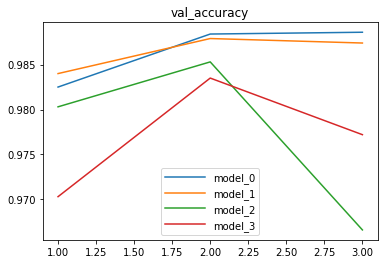

In [38]:
import matplotlib.pyplot as plt
import matplotlib

models = [model1, model5, model6, model7]

fig, ax = plt.subplots()

for i, model in enumerate(models):
  val_accuracy = model.history.history["val_accuracy"]
  line1, = ax.plot([1,2,3], val_accuracy, label=f'model_{i}')

matplotlib.pyplot.title("val_accuracy")
ax.legend(handlelength=4)



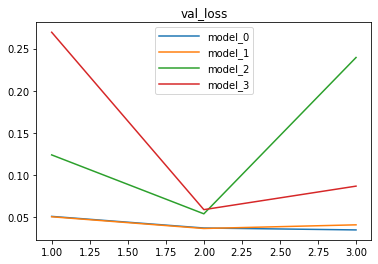

In [39]:
fig, ax = plt.subplots()

for i, model in enumerate(models):
  val_loss = model.history.history["val_loss"]
  line1, = ax.plot([1,2,3], val_loss, label=f'model_{i}')

matplotlib.pyplot.title("val_loss")
ax.legend(handlelength=4)

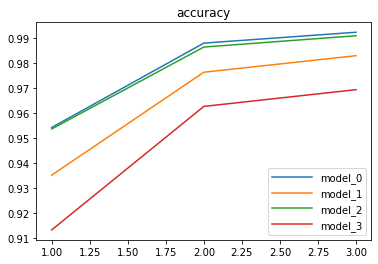

In [40]:
fig, ax = plt.subplots()

for i, model in enumerate(models):
  accuracy = model.history.history["accuracy"]
  line1, = ax.plot([1,2,3], accuracy, label=f'model_{i}')

matplotlib.pyplot.title("accuracy")
ax.legend(handlelength=4)

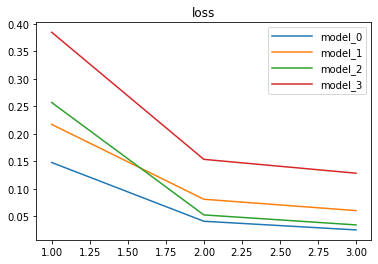

In [41]:
fig, ax = plt.subplots()

for i, model in enumerate(models):
  loss = model.history.history["loss"]
  line1, = ax.plot([1,2,3], loss, label=f'model_{i}')

matplotlib.pyplot.title("loss")
ax.legend(handlelength=4)